In [76]:
import matplotlib.pyplot as plt
import numpy as np
import typy
import pandas as pd
%matplotlib inline

In [2]:
from tqdm import tqdm

In [3]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()-2

In [4]:
work_dir = "/work/bansil/s.sevim/0_NbSe2_Work/0.00565"
outfolder="results_test"

In [5]:
nk = 256*256
nq = 2001
q_path = np.arange(nq)
nph = 9

In [6]:
# head -1000 gkk.out | grep -in "Size of q point mesh for interpolation:" | awk '{print $9}'
# head -1000 gkk.out | grep -in "Using uniform k-mesh:" | awk '{print $5}'
# head -1000 gkk.out | grep -in "Using uniform k-mesh:" | awk '{print $6}'

In [7]:
ph = np.zeros(shape=(nph,nq))
g_abs = np.zeros(shape=(nph,nq,nk))
g_re = np.zeros(shape=(nph,nq,nk))
g_im = np.zeros(shape=(nph,nq,nk))
e_k = np.zeros(shape=(nq,nk))
e_kq = np.zeros(shape=(nq,nk))

In [8]:
# for i in range(nph):
#     ph[i] = np.loadtxt(f"{work_dir}/{outfolder}/omega/omega_{i+1}.dat").reshape(nq,nk).T[0]
#     g_abs[i] = np.loadtxt(f"{work_dir}/{outfolder}/gkk_abs/gkk_{i+1}.dat").reshape(nq,nk)
#     g_re[i] = np.loadtxt(f"{work_dir}/{outfolder}/gkk_re/gkk_{i+1}.dat").reshape(nq,nk)
#     g_im[i] = np.loadtxt(f"{work_dir}/{outfolder}/gkk_im/gkk_{i+1}.dat").reshape(nq,nk)
# e_k = np.loadtxt(f"{work_dir}/{outfolder}/enk/enk_{1}.dat").reshape(nq,nk)
# e_kq = np.loadtxt(f"{work_dir}/{outfolder}/enkq/enkq_{1}.dat").reshape(nq,nk)
# g_complex = g_re+1j*g_im

In [9]:
%%time
ph_df = pd.DataFrame()
g_abs_df = pd.DataFrame()
g_re_df = pd.DataFrame()
g_im_df = pd.DataFrame()
e_k_df = pd.DataFrame()
e_kq_df = pd.DataFrame()
for i in tqdm(range(nph)):
    ph_df[i]    = pd.read_csv(f"{work_dir}/{outfolder}/omega/omega_{i+1}.dat", delimiter=' ',header=None)
    g_abs_df[i] = pd.read_csv(f"{work_dir}/{outfolder}/gkk_abs/gkk_{i+1}.dat", delimiter=' ',header=None)
    g_re_df[i]  = pd.read_csv(f"{work_dir}/{outfolder}/gkk_re/gkk_{i+1}.dat", delimiter=' ',header=None)
    g_im_df[i]  = pd.read_csv(f"{work_dir}/{outfolder}/gkk_im/gkk_{i+1}.dat", delimiter=' ',header=None)
e_k_df  = pd.read_csv(f"{work_dir}/{outfolder}/enk/enk_{1}.dat", delimiter=' ',header=None)
e_kq_df = pd.read_csv(f"{work_dir}/{outfolder}/enkq/enkq_{1}.dat", delimiter=' ',header=None)

100%|██████████| 9/9 [07:36<00:00, 50.71s/it]


CPU times: user 7min 21s, sys: 35.5 s, total: 7min 56s
Wall time: 7min 53s


In [10]:
%%time
for i in range(nph):
    ph[i] = ph_df[i].values.reshape(nq,nk).T[0]
    g_abs[i] = g_abs_df[i].values.reshape(nq,nk)
    g_re[i] = g_re_df[i].values.reshape(nq,nk)
    g_im[i] = g_im_df[i].values.reshape(nq,nk)
e_k = e_k_df.values.reshape(nq,nk)
e_kq = e_kq_df.values.reshape(nq,nk)
g_complex = g_re+1j*g_im

CPU times: user 7.07 s, sys: 13.7 s, total: 20.8 s
Wall time: 20 s


In [11]:
del ph_df
del g_abs_df
del g_re_df
del g_im_df
del e_k_df
del e_kq_df

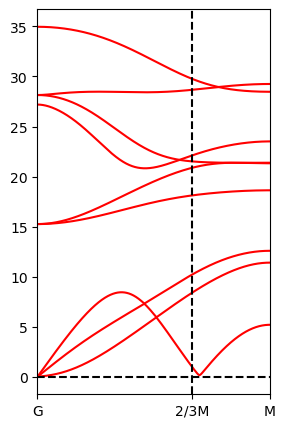

In [12]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(ph[i],c='r')
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
plt.show()

In [16]:
ef = 1.126000
delta=0.0000001

In [14]:
# %%time
# fsn = np.zeros(nq,dtype=complex)
# for q in tqdm(range(nq)):
#     temp_sum=0
#     for k in range(nk):
#         temp_sum+= (typy.fd(e_k[q][k]-ef)-typy.fd(e_kq[q][k]-ef))/(e_k[q][k]-e_kq[q][k]+1j*delta)
#         fsn[q]= -temp_sum/nk      

# $\chi(q) = -\sum_{k}\frac{fd(\xi(k)-\epsilon_f)-fd(\xi(k+q)-\epsilon_f)}{\xi(k)-\xi(k+q)+i\delta}$


In [15]:
class susceptibility:
    def __init__(self, e_k,e_kq,ef,delta):
        self.e_k = e_k
        self.e_kq = e_kq
        self.ef = ef
        self.delta = delta
        self.nk = e_k.shape[1]
    def calculate(self,q):
        temp_sum=0
        for k in range(self.nk):
            temp_sum+= (typy.fd(self.e_k[q][k]-self.ef)-typy.fd(self.e_kq[q][k]-self.ef))/(self.e_k[q][k]-self.e_kq[q][k]+1j*self.delta)
        return  -temp_sum/nk     
    def factor(self,q):
        temp_sum=0
        k_array = np.zeros(self.nk, dtype=complex)
        for k in range(self.nk):
            k_array[k] = (typy.fd(self.e_k[q][k]-self.ef)-typy.fd(self.e_kq[q][k]-self.ef))/(self.e_k[q][k]-self.e_kq[q][k]+1j*self.delta)
        return  -k_array

In [17]:
prep_suscep = susceptibility(e_k,e_kq,ef,delta)

In [18]:
%%time
suscep_results = Parallel(n_jobs=num_cores)(delayed(prep_suscep.calculate)(i) for i in range(nq))

CPU times: user 2.99 s, sys: 24.2 s, total: 27.2 s
Wall time: 1min 2s


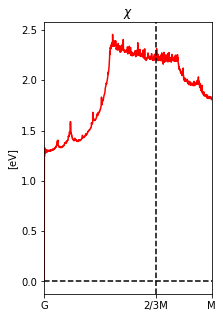

In [26]:
fig = plt.figure(figsize=(3,5))
plt.plot(np.array(suscep_results).real,c='r')
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
plt.ylabel(r"[eV]")
plt.title(r"$\chi$")
plt.savefig("./output/chi.jpg",bbox_inches='tight')
plt.show()

In [27]:
# %%time
# factor = np.zeros(shape=(nq,nk),dtype=complex)
# for q in tqdm(range(nq)):
#     for k in range(nk):   
#         factor[q][k]= -(typy.fd(e_k[q][k]-ef)-typy.fd(e_kq[q][k]-ef))/(e_k[q][k]-e_kq[q][k]+1j*delta)

In [20]:
%%time
factor_results = Parallel(n_jobs=num_cores)(delayed(prep_suscep.factor)(i) for i in range(nq))

CPU times: user 3.51 s, sys: 6.75 s, total: 10.3 s
Wall time: 40.7 s


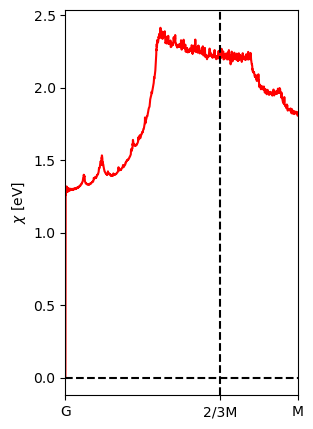

In [22]:
fig = plt.figure(figsize=(3,5))
plt.plot(np.array(factor_results).mean(axis=1).real,c='r')
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
plt.ylabel(r"$\chi$ [eV]")
# plt.savefig("./output/chi.jpg",bbox_inches='tight')
plt.show()

In [23]:
sum_array = []
for i in range(nph):
    for j in range(nph):
        if j>=i:
        # if i==j:
            for q in range(nq):
                sum_array.append([i,j,q])

In [24]:
class selfenergy:
    def __init__(self, g_complex,factor,sum_array):
        self.g_complex = g_complex
        self.g_conj = g_complex.conj()
        self.nph = g_complex.shape[0]
        self.nq = g_complex.shape[1]
        self.nk = g_complex.shape[2]
        self.factor = factor
        self.sum_array = sum_array
    def sum_over_k(self,index):
        i,j,q = self.sum_array[index]
        temp_sum=0
        for k in range(self.nk):
            epc = (self.g_complex[i][q][k]*self.g_conj[j][q][k])*10**-6
            temp_sum+=epc* self.factor[q][k]
        return temp_sum    

In [25]:
prep_selfen = selfenergy(g_complex,factor_results,sum_array)

In [27]:
import psutil

In [538]:
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 25.1
RAM Used (GB): 134.362198016


In [ ]:
%%time
results = Parallel(n_jobs=num_cores)(
            delayed(prep_selfen.sum_over_k)(i) for i in tqdm(range(len(sum_array))))

  1%|          | 1116/90045 [47:01<73:40:19,  2.98s/it]

In [ ]:
np.savetxt("output/off-selfen.dat",results)

In [31]:
selfen_matrix = np.zeros(shape=(nph,nph,nq),dtype=complex)

In [32]:
for i in range(len(sum_array)):
    mu,nu,q = sum_array[i]
    selfen_matrix[mu][nu][q]=results[i]

In [539]:
selfen_matrix.shape

(9, 9, 2001)

In [ ]:
# band1,band2, crossing = 1,2,919
# 1,2,919
# 0,1,1023
# 5,6,1222
# 7,8,1557

In [459]:
#band1,band2,cross
xs = [[1,2,920],
      [0,1,1024],
      [5,6,1223],
      [7,8,1558],
      [4,5,1662],
      [4,5,1764],]

In [460]:
def untangle(band,cross):
    fix = band.copy()
    num_cross = len(cross)
    for i in range(num_cross):
        temp_1 = fix[cross[i][0]].copy()
        temp_2 = fix[cross[i][1]].copy()
        point = cross[i][2]
        fix[cross[i][1]][:point] = temp_1[:point]
        fix[cross[i][0]][:point] = temp_2[:point]
    return fix

In [461]:
fixed_ph = untangle(ph,xs)

In [ ]:
# plt.savefig("./output/re_pi_g.jpg",bbox_inches='tight')


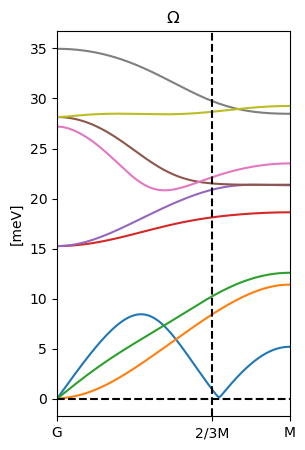

In [588]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(fixed_ph[i],label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
plt.ylabel(r"[meV]")
plt.title(r"$\Omega$")
plt.savefig("./output/phonon_separated.jpg",bbox_inches='tight')
# plt.legend()

plt.show()

In [463]:
g_complex_mean = g_complex.mean(axis=2)
g_complex_mean_conj = g_complex.conj().mean(axis=2)
g_complex_mean_sq = g_complex_mean*g_complex_mean_conj

In [503]:
fixed_g_complex_mean_sq = untangle(g_complex_mean_sq.real,xs)

In [504]:
fixed_g_complex_mean = np.sqrt(fixed_g_complex_mean_sq)

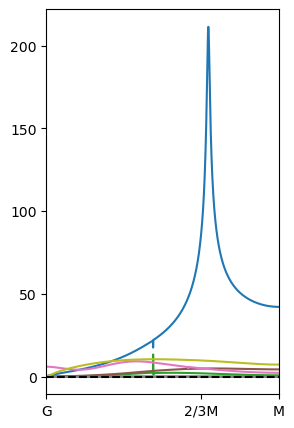

In [560]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(fixed_g_complex_mean[i],label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.show()

In [574]:
smooth_fixed_g_complex_mean = fixed_g_complex_mean.copy()
for i in range(nph):
    for j in range(100,nq):
        before = smooth_fixed_g_complex_mean[i][j-1]
        now = smooth_fixed_g_complex_mean[i][j]
        diff  = abs(now-before)
        rat = diff/now
        if(rat>0.1):
            # print(i,j,rat)
            smooth_fixed_g_complex_mean[i][j]=before
            # print("yes")

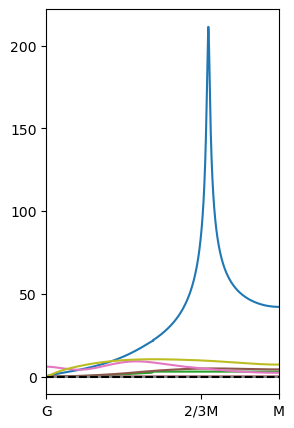

In [575]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(smooth_fixed_g_complex_mean[i],label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.show()

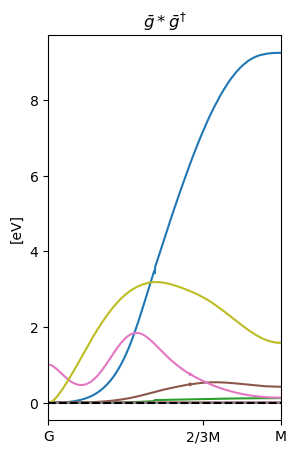

In [587]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(smooth_fixed_g_complex_mean[i]**2*(fixed_ph[i]*10**-3),label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axhline(0,c='black',linestyle="--")
plt.ylabel(r"[eV]")
plt.title(r"$\bar{g}*\bar{g}^{\dagger}$")
plt.savefig("./output/g_mean_separeted.jpg",bbox_inches='tight')
# plt.legend()
plt.show()

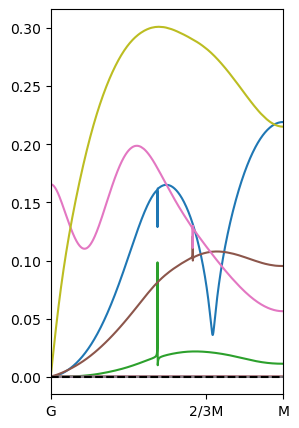

In [559]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(fixed_g_complex_mean[i]*(fixed_ph[i]*10**-3),label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.show()

In [553]:
smooth_fixed_selfen_diag_g = fixed_selfen_diag_g.copy()

for i in range(nph):
    for j in range(100,nq):
        before = smooth_fixed_g_complex_mean[i][j-1]
        now = smooth_fixed_g_complex_mean[i][j]
        diff  = abs(now-before)
        rat = diff/now
        if(rat>0.2):
            # print(i,j,rat)
            smooth_fixed_g_complex_mean[i][j]=before
            # print("yes")

IndexError: invalid index to scalar variable.

In [467]:
selfen_diag = np.zeros(shape=(nph,nq))
for i in range(nph):
    selfen_diag[i] = selfen_matrix[i][i].real

In [468]:
fixed_selfen_diag = untangle(selfen_diag,xs)

In [469]:
fixed_selfen_diag_g =  np.zeros(shape=(nph,nq))
for i in range(nph):
    fixed_selfen_diag_g[i] = fixed_selfen_diag[i]*(fixed_ph[i]*10**-3)

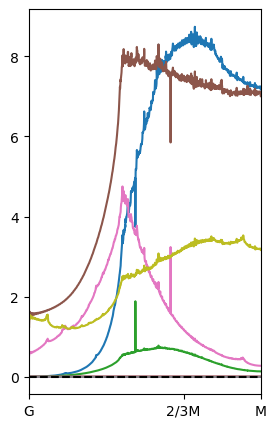

In [502]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(fixed_selfen_diag_g[i],label=i)
plt.xlim(0,nq)
# plt.xlim(1200,1250)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axhline(0,c='black',linestyle="--")
# plt.axvline(919)
# plt.legend()
plt.show()

In [500]:
smooth_fixed_selfen_diag_g = fixed_selfen_diag_g.copy()
for i in range(nph):
# for i in [0]:
    for j in range(100,nq):
        before = smooth_fixed_selfen_diag_g[i][j-1]
        now = smooth_fixed_selfen_diag_g[i][j]
        diff  = abs(now-before)
        rat = diff/now
        if(rat>0.2):
            # print(i,j,rat)
            smooth_fixed_selfen_diag_g[i][j]=before
            # print("yes")

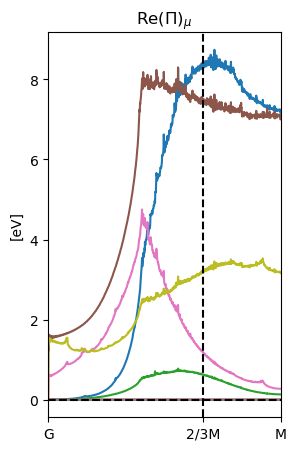

In [585]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.plot(smooth_fixed_selfen_diag_g[i],label=i)
plt.xlim(0,nq)
# plt.xlim(1200,1250)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axhline(0,c='black',linestyle="--")
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.ylabel(r"[eV]")
plt.title(r"Re$(\Pi)_{\mu}$" )
plt.savefig("./output/re_pi_diag_separated.jpg",bbox_inches='tight')
# plt.legend()
# plt.legend()
plt.show()

In [517]:
fixed_sum_array = []
for i in range(1):
    for j in range(nph):
        if j>=i:
        # if i==j:
            for q in range(nq):
                fixed_sum_array.append([i,j,q])

In [518]:
fixed_g_complex = untangle(g_complex,xs)

In [531]:
fixed_g_complex.shape

(9, 2001, 65536)

In [519]:
fixed_prep_selfen = selfenergy(fixed_g_complex,factor_results,fixed_sum_array)

In [591]:
# %%time
# fixed_results = Parallel(n_jobs=num_cores)(
#             delayed(fixed_prep_selfen.sum_over_k)(i) for i in tqdm(range(len(fixed_sum_array))))

In [ ]:
fixed_selfen_diag_g

In [ ]:
fixed_g_complex_mean = untangle(g_complex_mean_sq.real,xs)

In [ ]:
# selfen_diag_tile = np.zeros(nph*nq)
# for i in range(nph):
#     selfen_diag_tile[i*nq:(i+1)*nq] = selfen_matrix[i][i].real


In [ ]:
ph_tile = ph.flatten()

In [ ]:
path_tile = np.tile(np.arange(nq),9)

In [150]:
selfen_tile = np.zeros(shape=(nph,nq))
for i in range(nph):
    selfen_tile[i] = selfen_matrix[i][i].real
selfen_tile = selfen_tile.flatten()


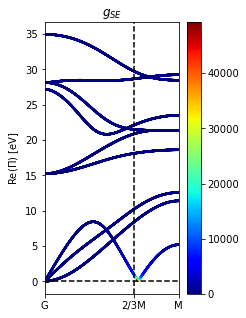

In [151]:
fig = plt.figure(figsize=(3,5))
plt.scatter(path_tile,ph_tile,c=selfen_tile,s=2,cmap='jet')
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.ylabel(r"Re($\Pi$) [eV]")
plt.title(r"$g_{SE}$")
plt.colorbar()
# plt.savefig("./output/re_pi_g.jpg",bbox_inches='tight')
plt.show()

In [141]:
selfen_matrix_g = np.zeros(shape=(nph,nq))
for i in range(nph):
    selfen_matrix_g[i] = selfen_matrix[i][i].real*(ph[i]*10**-3)
    

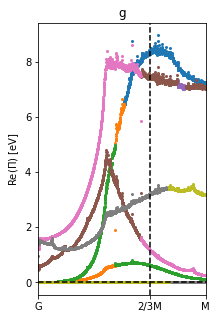

In [143]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.scatter(np.arange(nq),selfen_matrix_g[i],s=4,label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.ylabel(r"Re($\Pi$) [eV]")
plt.title(r"g")
# plt.savefig("./output/re_pi_g.jpg",bbox_inches='tight')
plt.show()

In [ ]:
selfen_g_tile = selfen_matrix_g.flatten()
# selfen_g_omega_tile = selfen_matrix_g_omega.flatten()

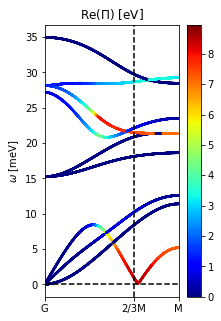

In [186]:
fig = plt.figure(figsize=(3,5))
plt.scatter(path_tile,ph_tile,c=selfen_g_tile,s=2,cmap='jet')
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.title(r"Re($\Pi$) [eV]")
plt.ylabel(r"$\omega$ [meV]")
# plt.title(r"g")
plt.colorbar()
plt.savefig("./output/re_pi_g.jpg",bbox_inches='tight')
plt.show()

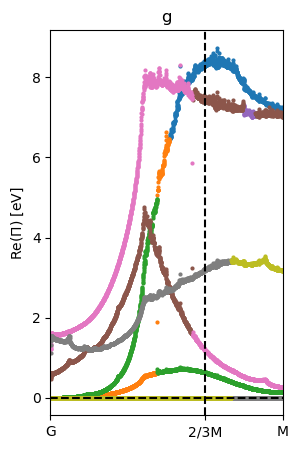

In [590]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.scatter(np.arange(nq),selfen_matrix[i][i].real*10**-3*ph[i][:nq],s=4,label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.ylabel(r"Re($\Pi$) [eV]")
plt.title(r"g")
# plt.savefig("./output/re_pi_g.jpg",bbox_inches='tight')
plt.show()

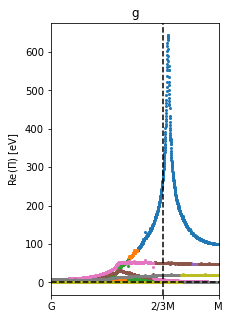

In [82]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.scatter(np.arange(nq),selfen_matrix[i][i].real*np.sqrt(10**-3*ph[i][:nq]),s=4,label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.ylabel(r"Re($\Pi$) [eV]")
plt.title(r"g")
# plt.savefig("./output/re_pi_g.jpg",bbox_inches='tight')
plt.show()

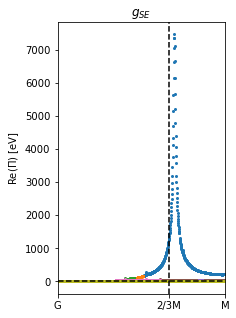

In [152]:
g_abs_mean = g_abs.mean(axis=2)

In [153]:
g_abs_mean.shape

(9, 2001)

In [166]:
g_abs_mean_tile = g_abs_mean.flatten()

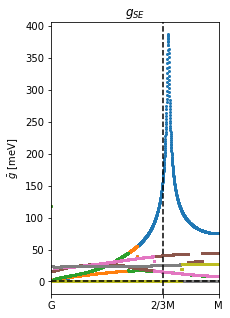

In [167]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.scatter(np.arange(nq),g_abs_mean[i],s=4,label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.ylabel(r"$\bar{g}$ [meV]")
plt.title(r"$g_{SE}$")
# plt.savefig("./output/gse_bar.jpg",bbox_inches='tight')
plt.show()

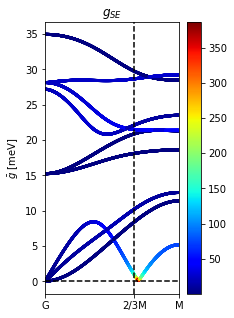

In [171]:
fig = plt.figure(figsize=(3,5))
plt.scatter(path_tile,ph_tile,c=g_abs_mean_tile,cmap='jet',s=4,label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.ylabel(r"$\bar{g}$ [meV]")
plt.title(r"$g_{SE}$")
# plt.savefig("./output/gse_bar.jpg",bbox_inches='tight')
plt.colorbar()
plt.show()

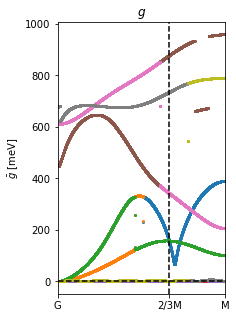

In [163]:
fig = plt.figure(figsize=(3,5))
for i in range(nph):
    plt.scatter(np.arange(nq),g_abs_mean[i]*ph[i][:nq],s=4,label=i)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.ylabel(r"$\bar{g}$ [meV]")
plt.title(r"$g$")
# plt.savefig("./output/gbar.jpg",bbox_inches='tight')
plt.show()

In [158]:
g_abs_mean_g = np.zeros(shape=(nph,nq))
for i in range(nph):
    g_abs_mean_g[i] = g_abs_mean[i]*ph[i]

In [159]:
g_abs_mean_g_tile = g_abs_mean_g.flatten()

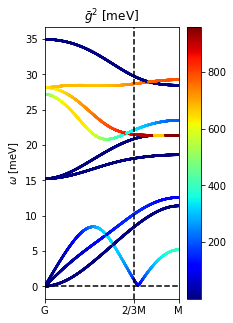

In [184]:
fig = plt.figure(figsize=(3,5))
plt.scatter(path_tile,ph_tile,c=g_abs_mean_g_tile,cmap='jet',s=2)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.title(r"$\bar{g}^2$ [meV]")
plt.ylabel(r"$\omega$ [meV]")
plt.colorbar()
plt.savefig("./output/gbar.jpg",bbox_inches='tight')
plt.show()

In [174]:
suscep_tile = np.tile(np.array(suscep_results).real,9)

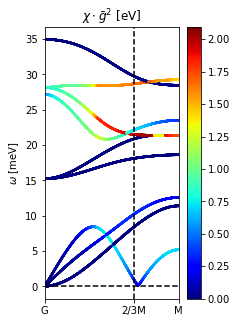

In [182]:
fig = plt.figure(figsize=(3,5))
plt.scatter(path_tile,ph_tile,c=suscep_tile*g_abs_mean_g_tile*10**-3,cmap='jet',s=2)
plt.xlim(0,nq)
plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
plt.axvline(nq*2/3,c='black',linestyle="--")
plt.axhline(0,c='black',linestyle="--")
# plt.legend()
plt.title(r"$\chi \cdot \bar{g}^2$ [eV]")
plt.ylabel(r"$\omega$ [meV]")
# plt.title(r"$g$")
plt.colorbar()
plt.savefig("./output/chig.jpg",bbox_inches='tight')
plt.show()

In [64]:
g_abs.mean(axis=2).shape

(9, 1000)

In [82]:
# %%time
# selfen = np.zeros(shape=(nph,nph,nq),dtype=complex)
# for i in range(9):
#     for j in range(9):
#         if j>=i:
#             for q in range(nq):
#                 temp_sum=0
#                 for k in range(nk):
#                     epc = (g_complex[i][q][k]*g_complex.conj()[j][q][k])*10**-6
#                     temp_sum+=epc* factor[q][k]
#                 print(q)
#                 selfen[i][j][q]=temp_sum/nk

In [ ]:
%%time
selfen = np.zeros(shape=(nph,nph,nq),dtype=complex)
for i in range(nph):
    for j in range(nph):
        for q in range(nq):
            temp_sum=0
            for k in range(nk):
                epc = (g_complex[i][q][k]*g_complex.conj()[j][q][k])*10**-6
                temp_sum+=epc* (typy.fd(e_k[q][k]-ef)-typy.fd(e_kq[q][k]-ef))/(e_k[q][k]-e_kq[q][k]+1j*delta)
            selfen[i][j][q]=-temp_sum/nk

# $\Pi_{\mu\nu}(q) = -\sum_{k}g^{\mu}_{k,k+q}g^{\nu\star}_{k,k+q}\frac{fd(\xi(k)-\epsilon_f)-fd(\xi(k+q)-\epsilon_f)}{\xi(k)-\xi(k+q)+i\delta} $

# $\begin{bmatrix} (\omega_q^{(1)})^2+2(\omega_q^{(1)})\Pi_{11} & 2\omega_q^{(1)}\Pi_{12} \\  2\omega_q^{(2)}\Pi_{21} & (\omega_q^{(2)})^2+2(\omega_q^{(2)})\Pi_{22} \end{bmatrix}$





In [26]:
q_path = np.linspace(0,0.5,1000,endpoint=False)
q_path = np.around(q_path,4)

In [28]:
# for i in range(1000):
#     print(q_path[i],0,0,0.0005)